In [98]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

In [99]:
total_steps= 1400
dt= 1

Forward integration
---
Forward integration of minimal "network" of one output neuron receiving specified or Poisson distributed (with Gaussian bell-curve rate function) "hidden spikes".

Note the correction to w - this makes the integral of teh PSC the same for different dt; however, differences obviously then remain for the PSP.

In [121]:
def forward(total_steps, dt, when):
    if type(when) is list:
        print("explicit hidden spike times")
        stim_steps= when
        explicit= True
    else:
        explicit= False
        r_max= when
        stim_steps= []
    mid= 200
    sigma= 200
    V= 0.0
    I= 0.0
    tau_m= 20.0
    tau_s= 5.0
    w= 1.0*(tau_s * (1.0 - np.exp(-dt / tau_s))) * (1.0 / dt)
    V_rec= np.zeros(total_steps)
    I_rec= np.zeros(total_steps)
    for iT in range(total_steps):
        #V= V+1.0/tau_m*(I-V)*dt
        V= tau_s/(tau_m-tau_s)*I*(np.exp(-dt/tau_m)-np.exp(-dt/tau_s))+V*np.exp(-dt/tau_m)
        I= I*np.exp(-dt/tau_s)
    
        if explicit:
            if iT in stim_steps:
                I= I+w
        else:
            p_rate= r_max/1000*np.exp(-(iT*dt-mid)*(iT*dt-mid)/(2*sigma*sigma))*dt
            if np.random.rand() < p_rate:
                I= I+w
                stim_steps.append(iT)
        V_rec[iT]= V
        I_rec[iT]= I
    return V_rec, I_rec, stim_steps

Output neuron membrane potential
---
We first calculate the membrane potential for an output neuron that is connected through a positive weight to a single hidden neuron spiking at specified spike times.

In [122]:
V_rec, I_rec, stim_steps= forward(total_steps, dt, [ 100, 150 ])
print(np.mean(V_rec))
print(np.mean(I_rec))
print(stim_steps)

explicit hidden spike times
0.0064685114737184106
0.007142857142857143
[100, 150]


Time step issues
---
The results do depend on the chosen timestep - so for maximum clarity, here the same forward dynamics with a very small timestep

In [123]:
total_steps_2= 140000
dt_2= 0.01
stim_steps_2= list(np.array(stim_steps)*(dt/dt_2))

In [124]:
V_rec_2, I_rec_2, stime_steps_2= forward(total_steps_2, dt_2, stim_steps_2)
print(np.mean(V_rec_2))
print(np.mean(I_rec_2))

explicit hidden spike times
0.007135718450596187
0.0071428571428571435


Plot the results for both time steps in comparison

<IPython.core.display.Javascript object>


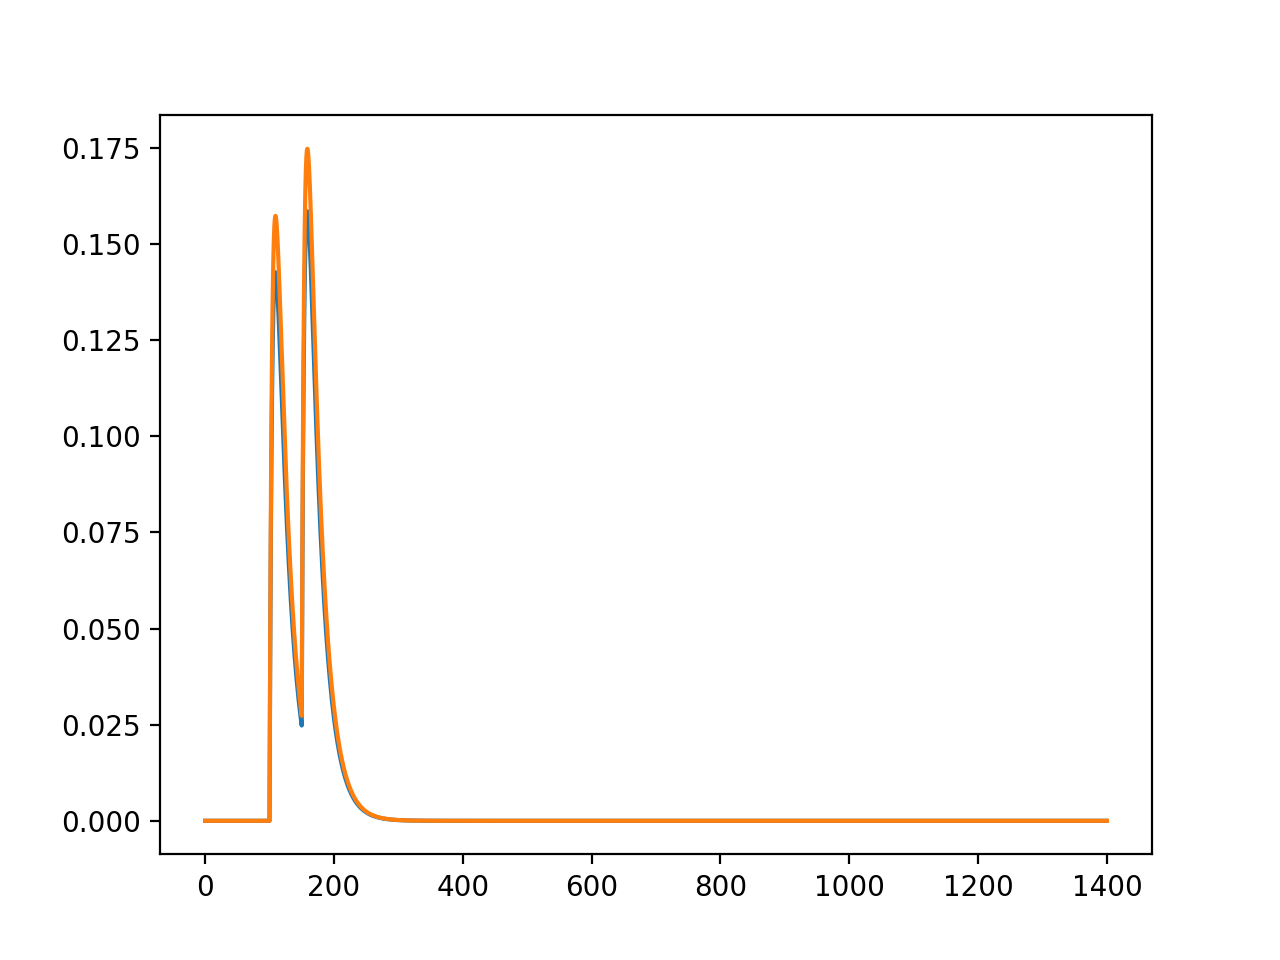

<IPython.core.display.Javascript object>


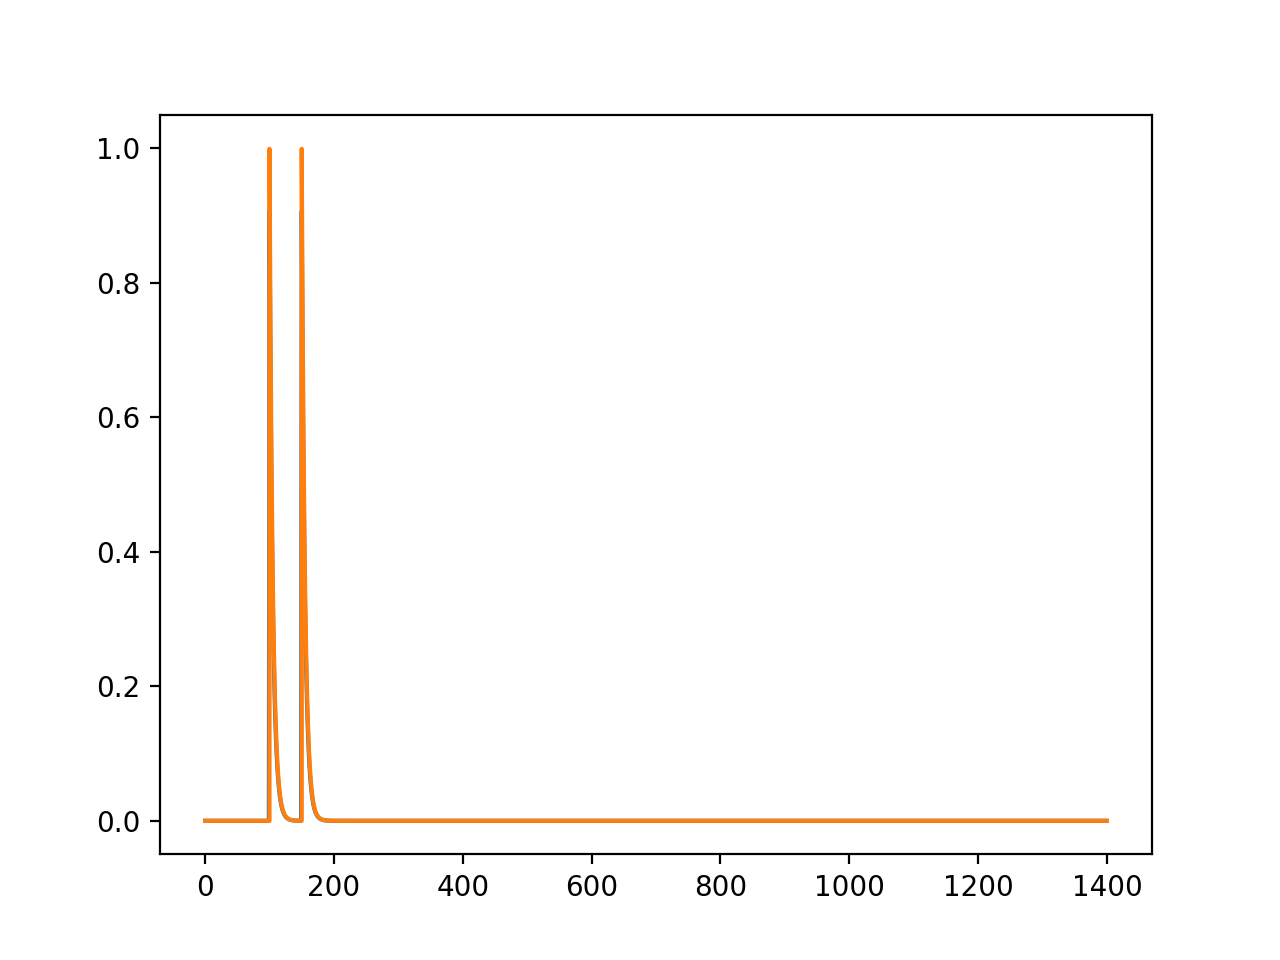

<IPython.core.display.Javascript object>


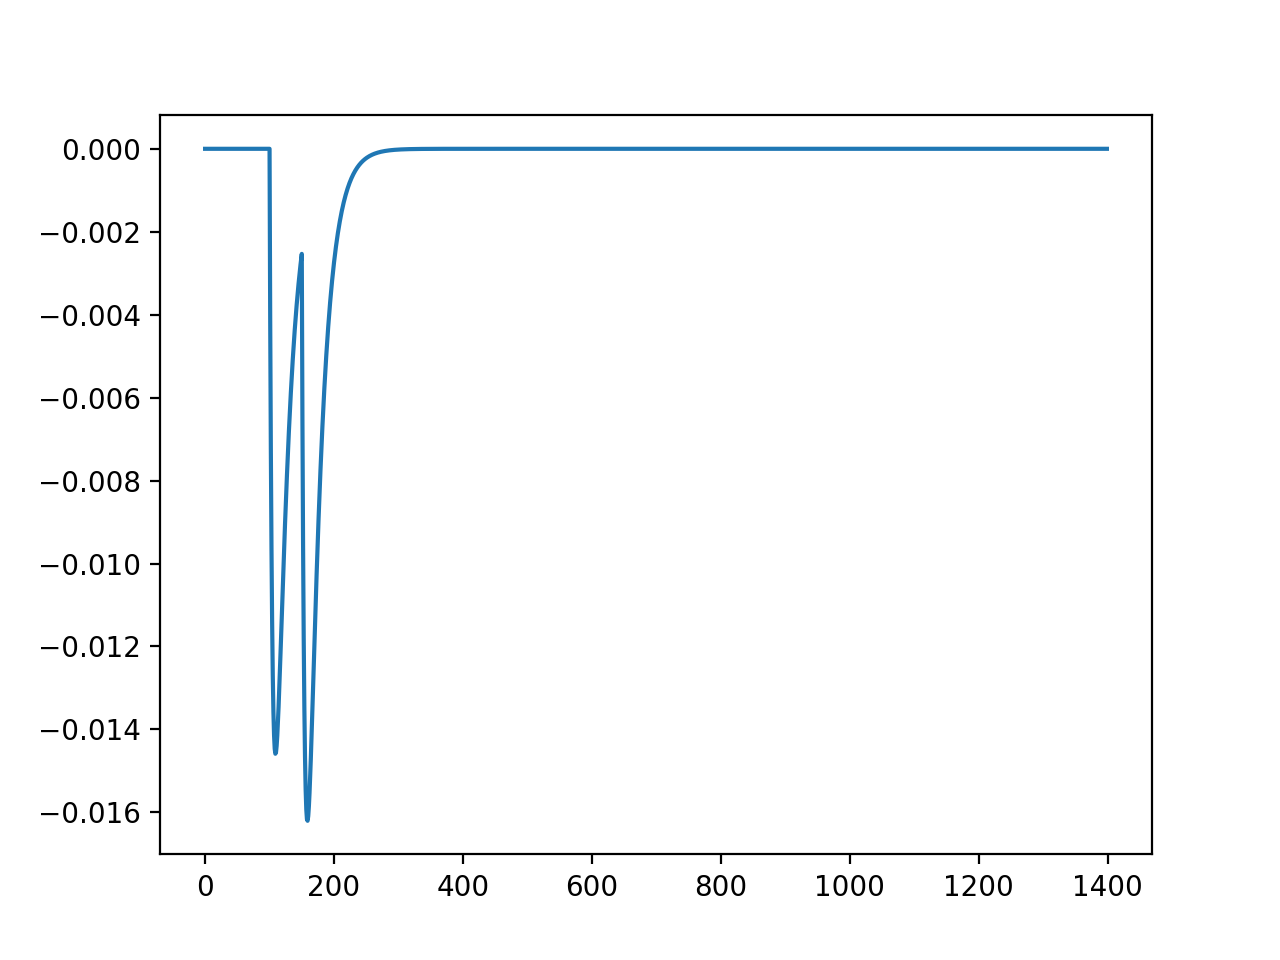

In [125]:
plt.figure()
plt.plot(np.arange(total_steps)*dt,V_rec)
plt.plot(np.arange(total_steps_2)*dt_2,V_rec_2)
plt.figure()
plt.plot(np.arange(total_steps)*dt,I_rec)
plt.plot(np.arange(total_steps_2)*dt_2,I_rec_2)
plt.figure()
plt.plot(np.arange(total_steps)*dt,V_rec-V_rec_2[::100])

Back-propagating "error" 
---
We assume a simple scenario where we have one hidden neuron, 20 output neurons, as in the Spiking Heidelberg Digits and investigate the back-propagated signal from the correct output neuron given some input pattern to the hidden neuron. For the analysis we will first assume that the weight from the hidden neuron to the correct output neuron is positive, i.e. the hidden neuron is correctly driving up the voltage of the correct output neuron.

In [126]:
def backward(total_steps, V_rec):
    lambda_V= 0.0
    lambda_I= 0.0
    lbdv_rec= []
    lbdi_rec= []
    for iT in range(total_steps,0,-1):
        lambda_I = lambda_I + (lambda_V - lambda_I)/tau_s*dt;
        lbdv= lambda_V
        # sum of exponential terms - all other voltages are 0
        mexp= np.exp(V_rec[iT-1])+19
        lambda_V= lambda_V + (1.0-np.exp(V_rec[iT-1])/mexp)/tau_m*dt-lbdv/tau_m*dt
        lbdv_rec.append(lambda_V)
        lbdi_rec.append(lambda_I)
    
    lbdv_rec= np.array(lbdv_rec)
    lbdi_rec= np.array(lbdi_rec)
    return lbdv_rec, lbdi_rec

<IPython.core.display.Javascript object>


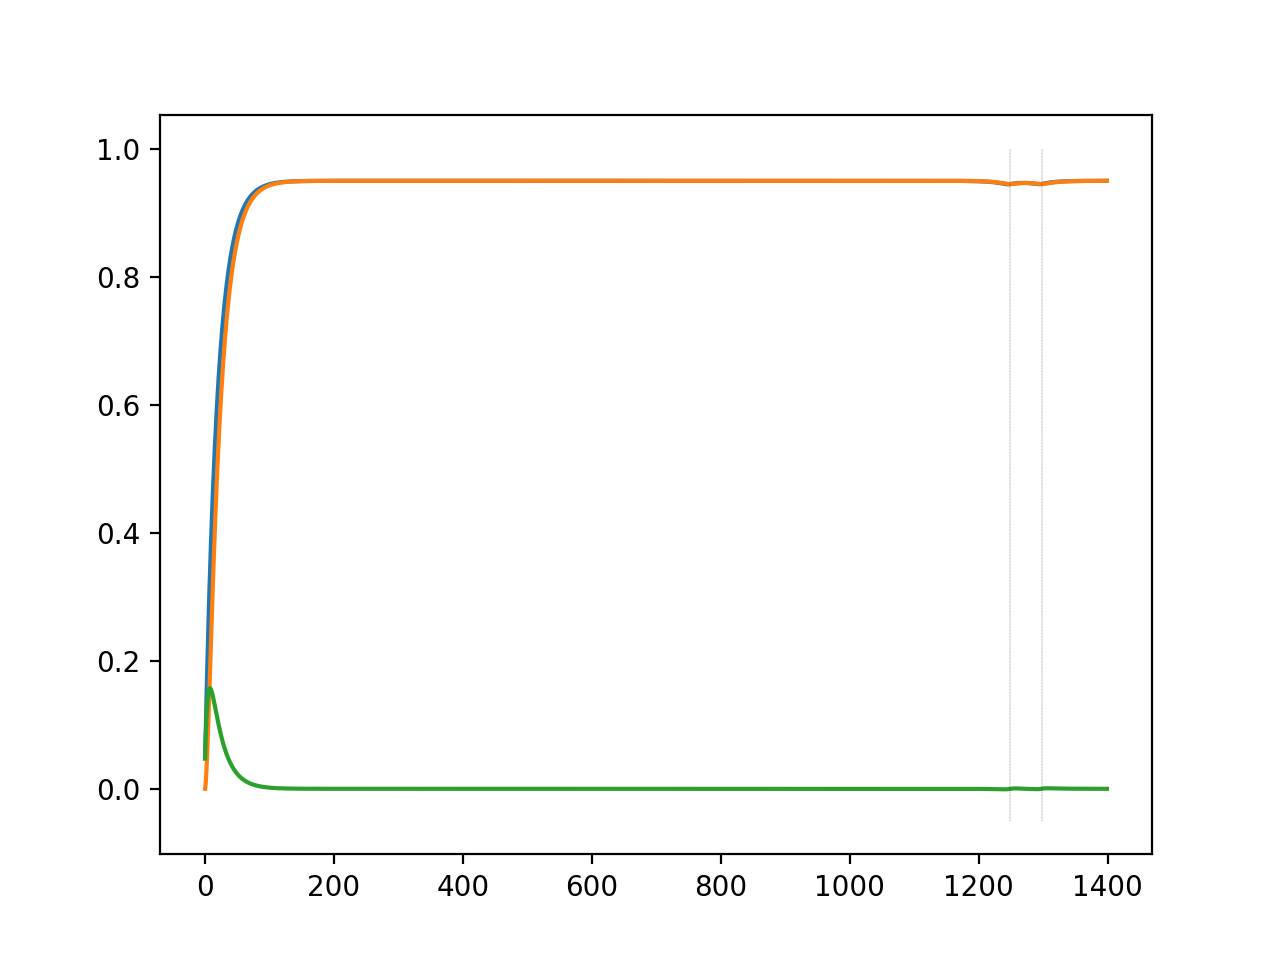

[[1299 1249]
 [1299 1249]]
[[-0.05 -0.05]
 [ 1.    1.  ]]
[1299 1249]
[3.02033966e-04 5.71670902e-05]
0.00035920105593634233


In [127]:
lbdv_rec, lbdi_rec= backward(total_steps, V_rec)
plt.figure()
plt.plot(np.arange(total_steps)*dt,lbdv_rec)
plt.plot(np.arange(total_steps)*dt,lbdi_rec)
plt.plot(np.arange(total_steps)*dt,lbdv_rec-lbdi_rec)
pos= total_steps-np.array(stim_steps)-1
lnsx= np.vstack([pos, pos])*dt
lnsy= np.vstack([[-0.05]*len(stim_steps), [1]*len(stim_steps)])
plt.plot(lnsx,lnsy,'--k',lw=0.1)
print(lnsx)
print(lnsy)
print(pos)
print(lbdv_rec[pos]-lbdi_rec[pos])
print(sum(lbdv_rec[pos]-lbdi_rec[pos]))

Playing with different hidden layer spike timings, we observe that close by spikes are moved apart, including sometimes a negative transport of lambda_v-lambda_I but generally lambda_V-lambda_I appears to be positive. This in itself does not explain the problems with the gradient in the hidden layer in the full simulation.

More systematic assessment
---
Let's repeat the analysis with poisson distributed "hidden spikes" a few times and look at the average backpropagated lambda_V-lambda_I

In [150]:
lv_li= []
total_lv_li= []
for r_max in [ 10, 20, 50, 100, 200]:
    for rep in range(10):
        V_rec, I_rec, stim_steps= forward(total_steps, dt, r_max)
        lbdv_rec, lbdi_rec= backward(total_steps, V_rec)
        try:
            pos= total_steps-np.array(stim_steps)-1
            lv_li.append(list(lbdv_rec[pos]-lbdi_rec[pos]))
            total_lv_li.append(sum(lbdv_rec[pos]-lbdi_rec[pos]))
        except:
            print(stim_steps)
        
print(total_lv_li)
avg_lv_li= np.mean(np.array(total_lv_li).reshape((5,10)), axis=1)                

[0.0006202644175196115, 0.0005079517343533624, 0.0012512256294447965, 0.00055962766464146, 0.0005583825336266113, 0.0009105283352512927, 0.0019117198365692367, 0.0007362741535941186, 0.0003735261660362532, 0.0007330234941697045, 0.0026009345613161594, 0.0016921669217030422, 0.001382481568408922, 0.001271450586283307, 0.0016583257053210954, 0.0020547370780933383, 0.0014047391364326867, 0.0011301031135307893, 0.00124127409025232, 0.002371876882454549, 0.003652917612898654, 0.003268370041401125, 0.004492599219289017, 0.003466371320527406, 0.006343496797881487, 0.003692047818682598, 0.0038403142905005794, 0.0066621182388622024, 0.004614353368036728, 0.00512027239550461, 0.011232182791609757, 0.011255872752409468, 0.006200802865397703, 0.012228694143924246, 0.010598616138162487, 0.009748433050238314, 0.00994918442863435, 0.00912552128871369, 0.014403398733346173, 0.005697783469820861, 0.025027270855290995, 0.034289996788534616, 0.02054156592324785, 0.029548812761116983, 0.02916211152712378,

<IPython.core.display.Javascript object>


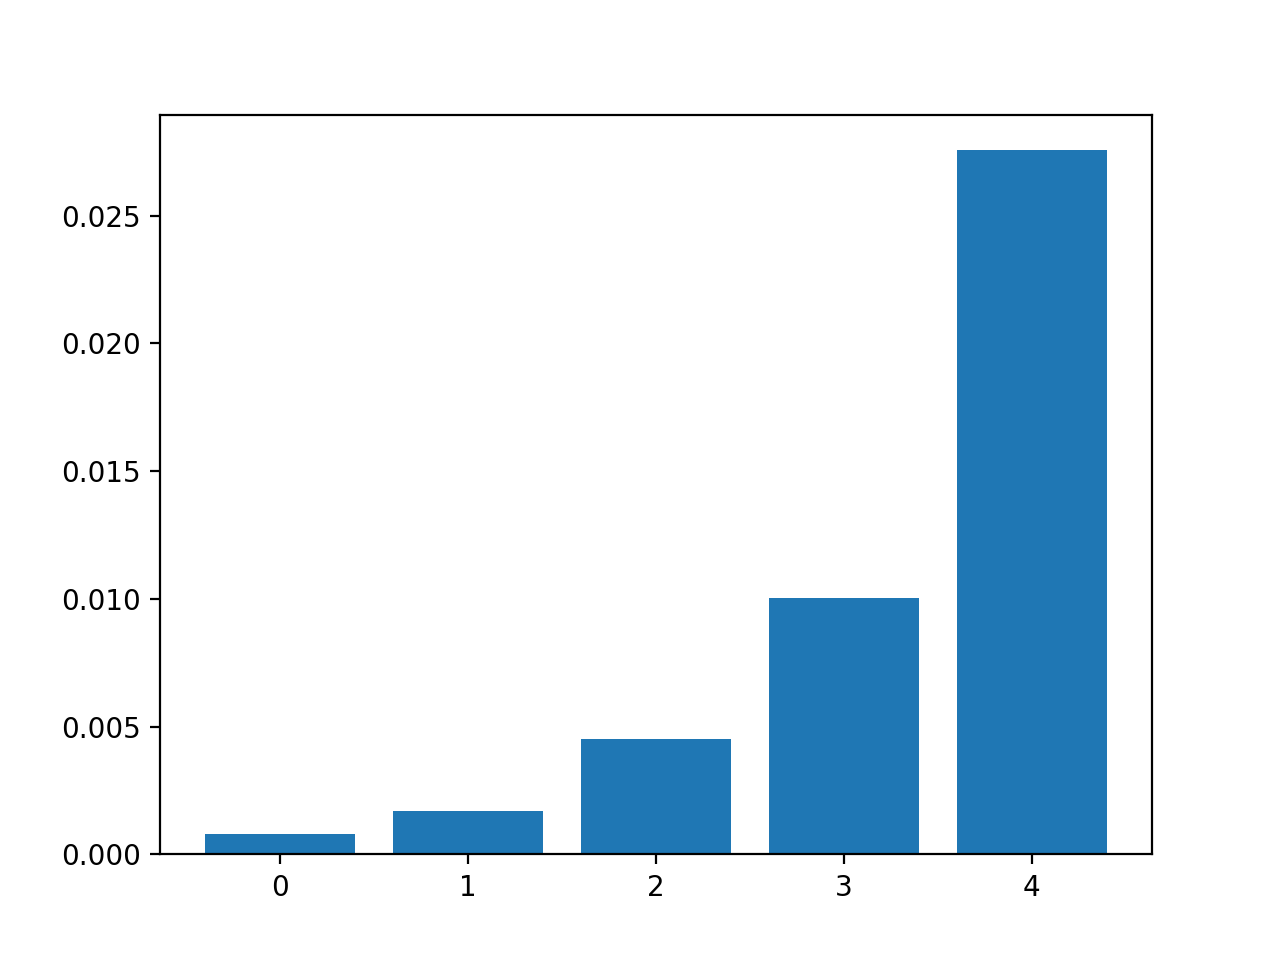

(5,)


<IPython.core.display.Javascript object>


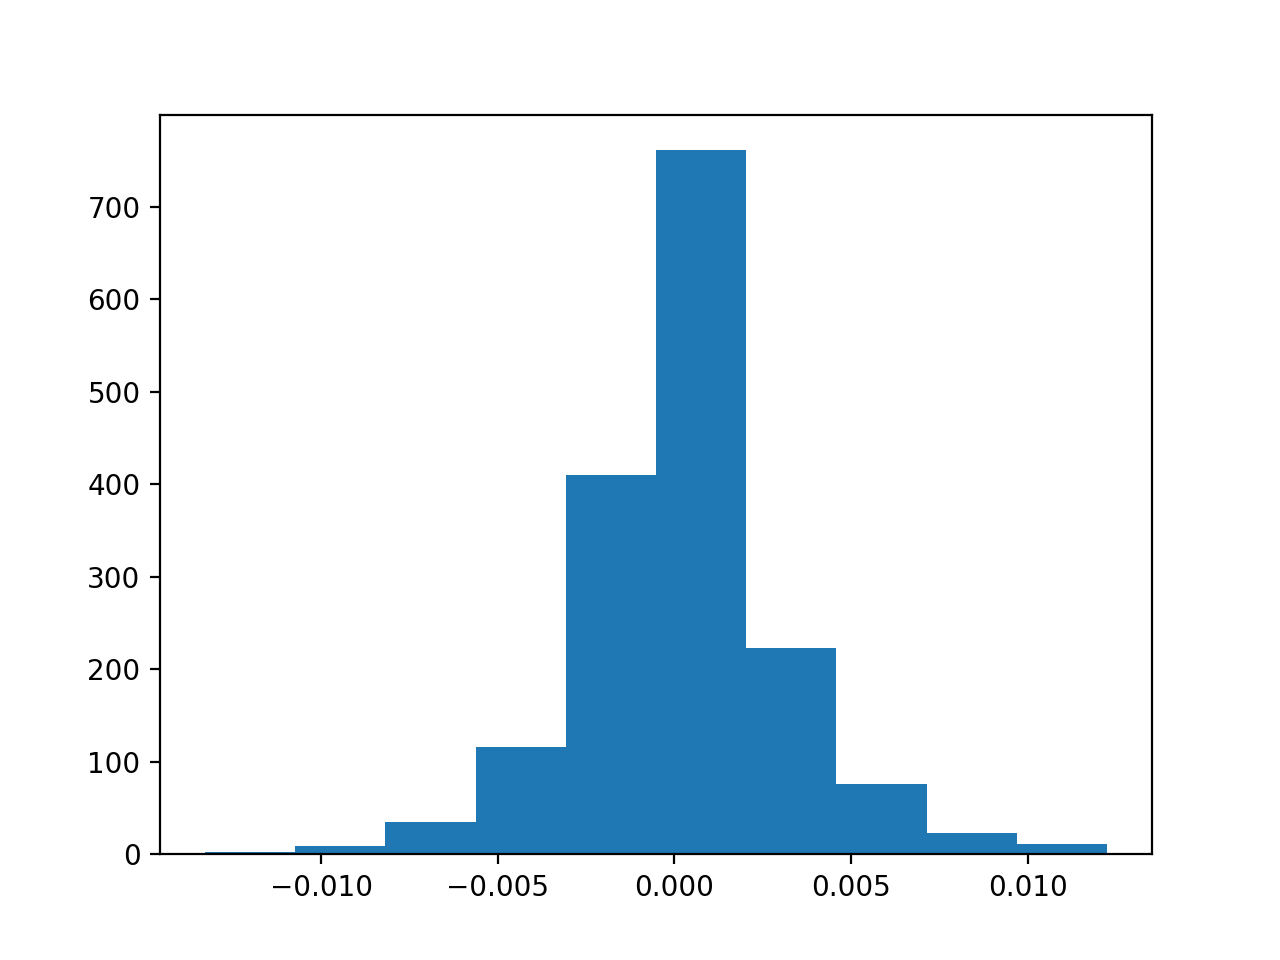

(array([  3.,   9.,  35., 116., 410., 761., 223.,  76.,  23.,  11.]),
 array([-0.01328311, -0.0107301 , -0.00817709, -0.00562408, -0.00307108,
        -0.00051807,  0.00203494,  0.00458795,  0.00714096,  0.00969396,
         0.01224697]),
 <BarContainer object of 10 artists>)

In [151]:
plt.figure()
print(avg_lv_li.shape)
plt.bar(np.array(range(5)),avg_lv_li)
plt.figure()
lv_li= [ item for sublist in lv_li for item in sublist]
plt.hist(np.array(lv_li))

Look at the back-propagated lambda for cross-entropy of integrals loss
---

<IPython.core.display.Javascript object>


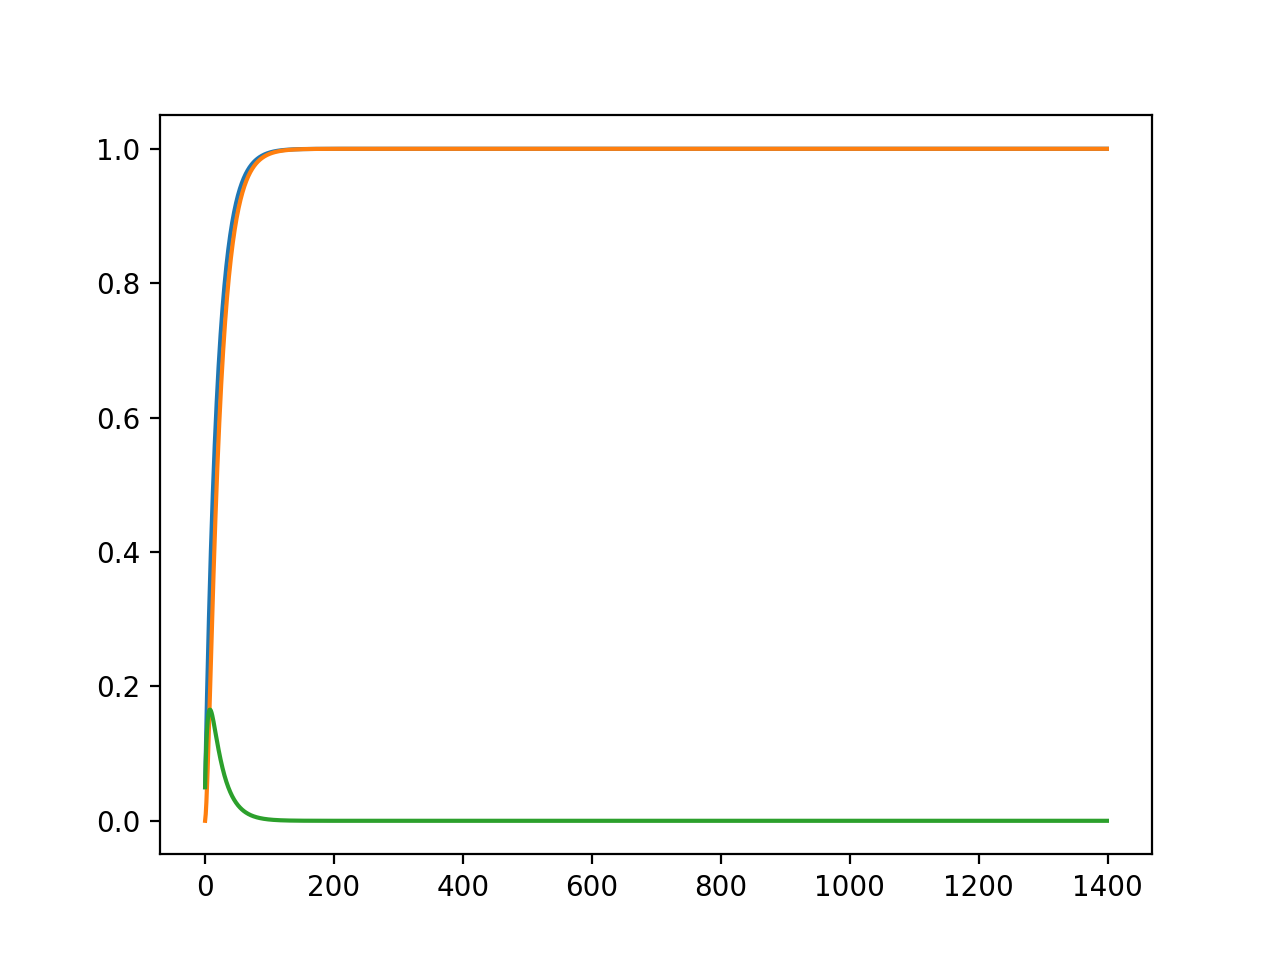

5.000000000000002


In [147]:
tau_m= 20.0
tau_s= 5.0
lambda_V= 0.0
lambda_I= 0.0
lbdv_rec= []
lbdi_rec= []
for iT in range(total_steps,0,-1):
    lambda_I = lambda_I + (lambda_V - lambda_I)/tau_s*dt
    lambda_V = lambda_V + (1-lambda_V)/tau_m*dt
    lbdv_rec.append(lambda_V)
    lbdi_rec.append(lambda_I)
lbdv_rec= np.array(lbdv_rec)
lbdi_rec= np.array(lbdi_rec)

plt.figure()
plt.plot(np.arange(total_steps)*dt,lbdv_rec)
plt.plot(np.arange(total_steps)*dt,lbdi_rec)
plt.plot(np.arange(total_steps)*dt,lbdv_rec-lbdi_rec)
print(sum(lbdv_rec-lbdi_rec))

Quick picture of an EPSP

<IPython.core.display.Javascript object>


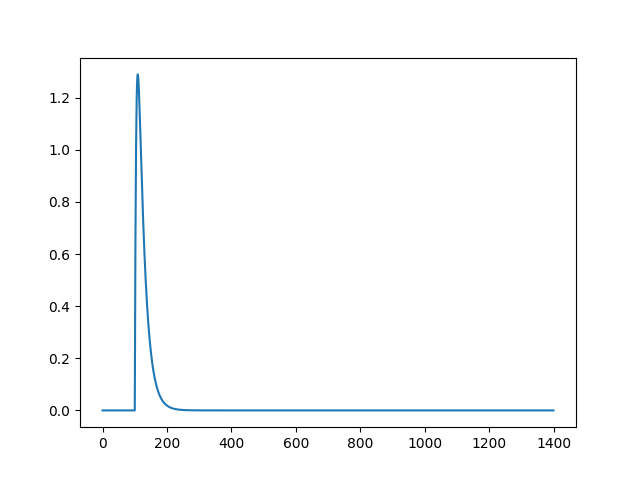

In [61]:
V= 0.0
I= 0.0
w= 10.0
tau_m= 20.0
tau_s= 5.0
V_rec= np.zeros(total_steps)
stim_steps= [ 100 ]
for iT in range(total_steps):
    #V= V+1.0/tau_m*(I-V)*dt
    V= tau_s/(tau_m-tau_s)*I*(np.exp(-dt/tau_m)-np.exp(-dt/tau_s))+V*np.exp(-dt/tau_m)
    if iT in stim_steps:
        I= I+w
    I= I*np.exp(-dt/tau_s)
    V_rec[iT]= V
    
plt.figure()
plt.plot(np.arange(total_steps)*dt,V_rec)
